<a href="https://colab.research.google.com/github/Guillem96/zsl-pytorch/blob/master/examples/birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git clone https://github.com/Guillem96/zsl-pytorch
# !cp -r zsl-pytorch/* .

In [0]:
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [0]:
# !pip install wikipedia
# !cd data && source download-birds.sh

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
import sys
import random
from pathlib import Path

import torch
import numpy as np

import zsl

In [0]:
BASE_PATH = Path('data/birds/150')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set random seed for reproducibility. `zsl` sets the random seed for:

- Python `random` package.
- `numpy`
- `torch`

In [0]:
zsl.seed(0)

## Getting ready for Zero Shot Learning

1. Split the classes in Zero Shot Classes and non Zero Shot. In other words, decide which classes are going to be available during training, and which not.
2. Declare a function that given the class name, looks for the bird description on wikipedia.

In [8]:
with (BASE_PATH / 'BIRDS-150.txt').open() as f:
    all_classes = [c.split(':')[1] for c in f.read().split(',') if c]

print('Number of classes:', len(all_classes))

Number of classes: 150


### Split the classes

We define a probability $P(C)$ that given a class $C$ it would belong to the Zero Shot Classes. In our case, we set a 20% of the classes.

$ P(C) = 0.2 $

In [9]:
PC = .2
classes, zs_classes = zsl.utils.split_classes(all_classes, PC)

print('Number of ZS classes:', len(zs_classes))
print('Number of NON-ZS classes:', len(classes))

Number of ZS classes: 26
Number of NON-ZS classes: 124


### Define a function to describe the labels

The text that describes the labels (birds), will come from wikipedia. To retrieve text from wikipedia corpus, we are going to use a convinient python package called `wikipedia`. With `wikipedia` package, we can retrieve summaries of the birds with a concrete number of sentences.

Later, we are going to encode the birds summaries in order the description matches with a pretrined embedding vocabulary, for example GloVe vectors.

First, we set the wikipedia language to english.


In [0]:
import wikipedia
wikipedia.set_lang('en')

`zsl` provides a convinien method to create summaries coming from wikipedia.

In [11]:
zsl.utils.wikipedia_description(classes[3], sentences=2)

'The American bittern (Botaurus lentiginosus) is a species of wading bird in the heron family. It has a Nearctic distribution, breeding in Canada and the northern and central parts of the United States, and wintering in the U.S. Gulf Coast states, all of Florida into the Everglades, the Caribbean islands and parts of Central America.'

We can see that wikipedia text contains a lot of uppercase letters and punctuations that we are not interested in. Thanks to `wikipedia_description` function, we can do some simple text cleaning. 

In [12]:
import functools

summary_fn = functools.partial(zsl.utils.wikipedia_description,
                               remove_punct=True,
                               to_lower=True)

summary_fn(zs_classes[3], sentences=2)

'the crested auklet  aethia cristatella  is a small seabird of the family alcidae  distributed throughout the northern pacific and the bering sea   the species feeds by diving in deep waters  eating krill and a variety of small marine animals '

Get descriptions for all labels, so later we can generate a vocabulary.

In [0]:
from tqdm import tqdm

# Map some classes that are not directly found in wikipedia
mapping_unknown = {
    'CHARA DE COLLAR': 'Cyanolyca armillata',
    'CURL CRESTED ARACURI': 'Pteroglossus beauharnaisii',
    'MYNA': 'MYNA BIRD',
    'RED WISKERED BULBUL': 'Red-whiskered bulbul',
    'ROBIN': 'Robin BIRD',
    'TEAL DUCK': 'Eurasian teal',
    'WILSONS BIRD OF PARADISE': 'Wilson\'s bird-of-paradise'}

all_texts_f = Path('.all_texts')
if all_texts_f.exists():
    all_texts = all_texts_f.open().read().split('\n')
else:
    all_texts = [summary_fn(mapping_unknown.get(c, c)) for c in tqdm(all_classes)]
    all_texts_f.open('w').write('\n'.join(all_texts))

We build a vocabulary using torchtext.

In [0]:
import torchtext
from collections import Counter

counter = Counter(' '.join(all_texts).split())
vocab = torchtext.vocab.Vocab(counter, 
                              vectors=torchtext.vocab.GloVe(name='6B', dim=300))

Now that our vocabulary is ready, we can see the semantic representation of any word.

For instance, let's see 'bird' representation

In [15]:
vocab.vectors[vocab.stoi['bird']]

tensor([ 0.3153,  0.6543, -0.2072, -0.4703, -0.2601, -0.1169, -0.0522,  0.2718,
        -0.3447, -0.6276,  0.4659, -0.0838, -0.4918, -0.0405, -0.2514,  0.2076,
        -0.0377, -0.0160, -0.2665, -0.7403,  0.0146,  0.5586, -0.2426,  0.2031,
         0.0533,  0.2582, -0.1165, -0.7504,  0.0295,  0.1133,  0.1825, -0.0840,
        -0.9860, -0.3176, -0.3159,  0.2155, -0.1164, -0.6697, -0.6341, -0.1234,
         0.0997, -0.0687,  0.4993,  0.4837, -0.1116, -0.1586,  0.9225, -0.1647,
         0.1448,  0.0264,  0.0478,  0.1761,  0.1509, -0.2412,  0.1324,  0.1843,
        -0.0918,  0.0161, -0.1071, -0.5169, -0.1736,  0.3805,  0.1885, -0.1386,
        -0.1142, -0.1112, -0.0565,  0.2526,  0.1740,  0.6494, -0.1029,  0.6015,
         0.1687,  0.0137, -0.3554,  0.5634,  0.4869,  0.1013,  0.3633, -0.1289,
        -0.0901,  0.1507, -0.2779, -0.1840,  0.4755, -0.0448,  0.5085,  0.3250,
        -0.5297, -0.2520,  0.1403, -0.3854, -0.1569,  0.2588,  0.2169,  0.3452,
         0.2048,  0.1600, -0.1429, -0.14

Finally we can create the function that maps a class to a tokenized description.
Later, we will convert tokens to semantic representation using an `nn.Embedding` containing the semantic representations.

In [16]:
def class_to_semantic(class_name):
    
    # Map the class to known words
    class_name = mapping_unknown.get(class_name, class_name)

    # Look for the description in wikipedia
    desc = summary_fn(class_name, sentences=2)

    # Tokenize and return the description
    return torch.LongTensor([vocab.stoi[w] for w in desc.split()])

print('Description of', zs_classes[0])
class_to_semantic(zs_classes[0])

Description of BLACKBURNIAM WARBLER


tensor([   1, 1327,  172,  586, 1502,  195, 2566, 1502,    5,    6,   40,   57,
          59,  172,   20,  291,    4,   87,   26,   30,   17,   69,  141, 4146,
           7,    1,   69,  965, 3507,    1,  142,  344,  861,    2,   57,  781,
           7,   26,  615])

Now we have already done one of the most complex tasks of Zero Shot Learning: Generating a semantic representation for the labels.

Now it is time to index our data using Pytorch datasets.

In [0]:
train_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'train', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    load_unseen=False) # In training set we don't load zs classes

Label: MYNA
Description: the myna also spelled mynah is a bird of the starling family sturnidae this is a group of passerine birds which are native to southern asia especially india pakistan and bangladesh


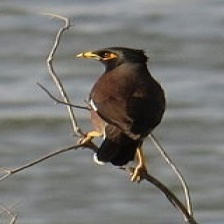

In [18]:
idx = random.randint(0, len(train_ds))
image, label, semantic = train_ds[idx]
print('Label:', train_ds.classes[label])
print('Description:', ' '.join(vocab.itos[i] for i in semantic.tolist()))

image

## Preparing the model

For the ZSL framework, we need two main models:

- `VisualFeatureExtractor`: It is a pretrained CNN that extract the features from an image. Usually it is a good practice to pretrain it with your use case. For sake of simplicity, in this examples we are going to use a pretrained ImageNet CNN.
- `SemanticUnit`: This model generates an embedding making transformations to the semantic representation of the label. In our case, we are going to apply an LSTM semantic unit with pretrained embeddings (`vocab.vectors`) to encode the birds description.


In [0]:
semantic_unit = zsl.models.BidirectionalSemanticUnit(vocab.vectors, 
                                                     vocab.stoi['<pad>'],
                                                     hidden_size = 512,
                                                     out_features = 512)

visual_fe = zsl.models.VisualFeatureExtractor(feature_extractor='resnet50',
                                              trainable=True)

In [20]:
print('Semantic repr shape:', semantic_unit(semantic.unsqueeze(0)).size())
print('Visual embedding shape:', visual_fe(torch.randn(1, 3, 224, 224)).size())

Semantic repr shape: torch.Size([1, 512])
Visual embedding shape: torch.Size([1, 2048])


Notice that the semantic and visual output does not have the same shape, therfore they do not have compatible shapes to operate between them.

To join the two models we are going to use the `zsl.models.ZeroShot` class.

In [21]:
zs_model = zsl.models.ZeroShot(visual_fe, semantic_unit)
zs_model.visual_fe.requires_grad = True
image_embed, semantic_embed = zs_model(torch.randn(1, 3, 224, 224),
                                       semantic.unsqueeze(0))
image_embed.size(), semantic_embed.size()

(torch.Size([1, 2048]), torch.Size([1, 2048]))

Now that shapes match, we can play with these tensors.

As always, we can alocate out model to the GPU.

In [0]:
zs_model.to(device);

### Model forward step

As usual, to do the model forward step, we need to batch our data and convert it to tensors. To do that, we are going to use 2 main tools:

- Torchvision transformations: They will allow us to convert our pillow images to tensors and also add data augmentation if needed.
- Torch DataLoaders: Dataloaders allow us to load our datasets in a batched manner. Also, they provide a lot of extra functionalities such as parallel loading and shuffling.

First, we define the transformations and the datasets with the transforms attached.

In [0]:
import torchvision.transforms as T

tfms = T.Compose([T.Resize(224, 224), T.ToTensor()])

train_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'train', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    transform=tfms,
    load_unseen=False)

valid_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'valid', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    transform=tfms,
    load_unseen=True)

test_ds = zsl.data.ZSLImageFolder(
    BASE_PATH / 'test', 
    class_to_repr=class_to_semantic,
    zero_shot_classes=zs_classes,
    transform=tfms,
    load_unseen=True)

In [24]:
idx = random.randint(0, len(train_ds))
image, label, semantic = train_ds[idx]

print('Image:', image.size())
print('Label:', train_ds.classes[label])
print('Description:', ' '.join(vocab.itos[i] for i in semantic.tolist()))

Image: torch.Size([3, 224, 224])
Label: BLACK-NECKED GREBE
Description: the black necked grebe podiceps nigricollis known in north america as the eared grebe is a member of the grebe family of water birds it was described in 1831 by christian ludwig brehm


In [0]:
from torch.utils.data import DataLoader

collate_fn = functools.partial(zsl.utils.collate_image_folder, 
                               padding_idx=vocab.stoi['<pad>'])

train_dl = DataLoader(train_ds, 
                      batch_size=32,
                      shuffle=True, 
                      collate_fn=collate_fn)

valid_dl = DataLoader(valid_ds, batch_size=16, collate_fn=collate_fn)

test_dl = DataLoader(test_ds, batch_size=16, collate_fn=collate_fn)

In [0]:
images, _, semantics = next(iter(train_dl))
images_embeds, semantics_embeds = zs_model(images.to(device), 
                                           semantics.to(device))

images_embeds.size(), semantics_embeds.size()

### Model training

In [0]:
parameters = [p for p in zs_model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(parameters, 1e-4)
criterion_fn = torch.nn.MSELoss()

In [0]:
def train_single_epoch(epoch):
    running_loss = 0.0
    for i, (images, _, semantics) in enumerate(train_dl):
        print('.', end='')
        sys.stdout.flush()

        images = images.to(device)
        semantics = semantics.to(device)

        visual_embeds, semantic_embed = zs_model(images, semantics)
        loss = criterion_fn(visual_embeds, semantic_embed)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(1.)
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 50 == 0:
            loss_mean = running_loss / float(i)
            print()
            print(f'Epoch [{epoch}] [{i}/{len(train_dl)}] '
                  f'loss: {loss_mean:.4f}')


@torch.no_grad()
def evaluate():
    def print_metrics(step):
        print()
        metrics = {m: v / step for m, v in running_metrics.items()}
        metrics_str = '  '.join(f'{m}: {v:.4f}' for m, v in metrics.items())
        print('Validation ', metrics_str)

    padded_descriptions = torch.nn.utils.rnn.pad_sequence(
        valid_ds.semantic_representations(), batch_first=True).to(device)
    all_classes_reprs = zs_model(semantic_repr=padded_descriptions)[0]

    running_metrics = {
        'loss': 0.,
        'accruacy': 0., 
        'top_5_accuracy': 0.}

    for i, (images, y_true, semantics) in enumerate(valid_dl):
        print('.', end='')
        sys.stdout.flush()

        images = images.to(device)
        semantics = semantics.to(device)
        y_true = y_true.to(device)

        visual_embeds, semantic_embed = zs_model(images, semantics)
        loss = criterion_fn(visual_embeds, semantic_embed)

        running_metrics['loss'] += loss.item()
        running_metrics['accruacy'] += zsl.nn.accuracy(
            visual_embeds, all_classes_reprs, y_true).item()
        running_metrics['top_5_accuracy'] += zsl.nn.top_5_accuracy(
            visual_embeds, all_classes_reprs, y_true).item()

        # if (i + 1) % 20 == 0:
        #     print_metrics(i)

    print_metrics(len(valid_dl))
    

In [0]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_single_epoch(epoch)
    print('Running validation', end='')
    evaluate()